<a href="https://colab.research.google.com/github/aadhibalaji/machinelearning/blob/main/Classification_model_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
#Load MNIST dataset
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
#Import all the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV


In [ ]:
dataset_path = '/content/drive/MyDrive/english.csv'
df = pd.read_csv(dataset_path)

#Set up dataframe to load in each image
imageInfo,y = df['image'],df['label']
counter = 0
length = len(df)

#Create new column for image data
df['ImageData']=None



print(length)


3410


In [ ]:
mnist_data = mnist.data
mnist_labels = mnist.target

num_samples = 2750
additional_samples = []
additional_labels = []


#Get 50 iterations of 55 samples for each class
for digit in range(10):
  digit_indices = np.where(mnist_labels == str(digit))[0]
  selected_indices = digit_indices[:num_samples]
  additional_samples.append(mnist_data[selected_indices])
  additional_labels.extend([digit] * num_samples)



additional_samples = np.concatenate(additional_samples)
additional_labels = np.array(additional_labels)




In [ ]:
imageData = []
labelData = []

counter = 0

#Iterate over all image digits to load each image and convert to grayscale, resize, and store them as arrays
for counter in range (549):
  image_path = imageInfo[counter]

  image = Image.open('/content/drive/MyDrive/'+ image_path)

  image = image.resize((28,28), Image.ANTIALIAS)

  gray_image = image.convert('L')
  image_matrix = np.array(gray_image)

  b=image_matrix.reshape(-1)
  imageData.append(b)

  labelData.append(df['label'].iloc[counter])



<ipython-input-6-ed89f351fb07>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((28,28), Image.ANTIALIAS)


In [ ]:
original_samples = imageData
original_labels = np.array(labelData)

#Add MNIST samples to original dataset
X = np.concatenate((original_samples, additional_samples))
y = np.concatenate((original_labels, additional_labels))

In [ ]:
#Split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split (X,y, test_size = 0.2, random_state = 42)

In [ ]:
#Encode all labels into binary
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

In [ ]:
#Fit model to the training set
model = SGDClassifier()
sgdc = model.fit(X_train,y_train)

In [ ]:
#Define function that scores the model on the testing set
def ml_test_model(model):
  score = model.score(X_test, y_test)
  return score

In [ ]:
#Call scoring function
ml_test_model(sgdc)

0.2545454545454545

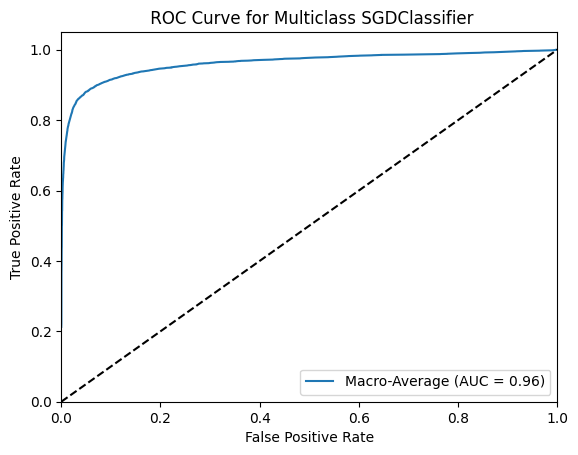

In [ ]:
#Get the scores for each class
y_scores = sgdc.decision_function(X_test)

#Binarize the labels for the classes of all digits
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

fpr = dict()
tpr = dict()
roc_auc = dict()

#Calculate the false positive rates and true positive rates for each class
for i in range(len(np.unique(y))):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


#Calculate the false positive and true positive rates for all classes
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(np.unique(y)))]))
mean_tpr = np.mean([np.interp(all_fpr, fpr[i], tpr[i]) for i in range(len(np.unique(y)))], axis=0)
macro_auc = auc(all_fpr, mean_tpr)


#Plot ROC curve
plt.figure()
plt.plot(all_fpr, mean_tpr, label=f'Macro-Average (AUC = {macro_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' ROC Curve for Multiclass SGDClassifier')
plt.legend(loc="lower right")
plt.show()